<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_16_ensemble_02_stacking_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### What is Stacking in Machine Learning

**Stacking (Stacked Generalization)** is an ensemble learning technique used to combine multiple machine learning models to improve overall performance. The fundamental idea behind stacking is to leverage the strengths of different models by combining their predictions to make more accurate and robust predictions.

#### What is Stacking?

1. **Base Models (Level-0 Models)**:
   - These are the individual models that are trained on the same dataset. Each base model may learn different aspects of the data, potentially making different types of errors.
   - Common base models include logistic regression, decision trees, random forests, support vector machines, and gradient boosting machines.

2. **Meta-Model (Level-1 Model)**:
   - The meta-model is trained to combine the predictions of the base models. It takes the outputs (predictions) of the base models as input features.
   - The meta-model learns to predict the final output based on the patterns and correlations it finds in the predictions of the base models.

3. **Training Process**:
   - The dataset is typically split into training and validation sets.
   - Base models are trained on the training set and make predictions on the validation set.
   - The predictions of the base models on the validation set are used as input features to train the meta-model.
   - In the final prediction phase, the base models make predictions on new data, and these predictions are fed into the meta-model to make the final prediction.

#### Why Use Stacking?

1. **Improved Performance**:
   - By combining the strengths of multiple models, stacking often results in better predictive performance than any single model alone.
   - Different models may capture different aspects of the data, and the meta-model can learn to weigh these appropriately.

2. **Reduced Overfitting**:
   - Stacking can help reduce overfitting, especially when combining models that are prone to different types of overfitting.
   - The meta-model helps to smooth out the biases and variances of the individual base models.

3. **Flexibility**:
   - Stacking allows the use of a wide variety of base models, including both linear and non-linear models.
   - It can be easily extended to include more complex meta-models, such as neural networks.

#### Experiment Summary

In this experiment, we aimed to predict loan defaults using various machine learning models and ensemble techniques. Our primary goal was to achieve high recall for identifying loan defaults (Class 1) while maintaining a balance with precision and F1 scores. The models evaluated included Logistic Regression, Random Forest, LightGBM, HistGradientBoosting, and a Voting Classifier combining these models.

We assessed each model's performance using recall, precision, and F1 scores for both classes (loan defaults and non-defaults). We focused on optimizing thresholds to balance recall and precision, especially for Class 1, given the importance of correctly identifying loan defaults.




### Stacking Model Classifier

[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 30
[LightGBM] [Info] [bin

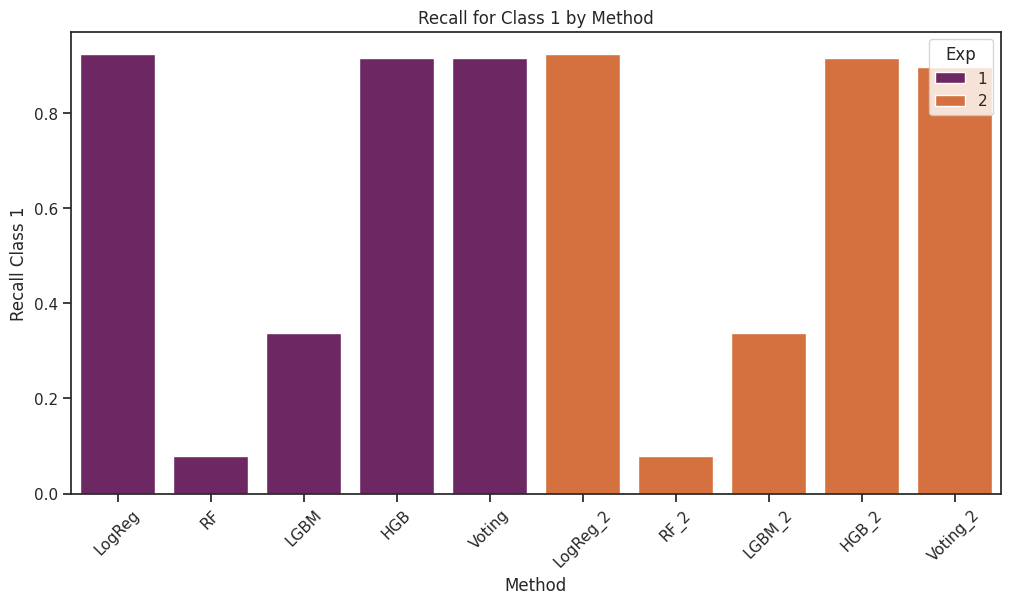

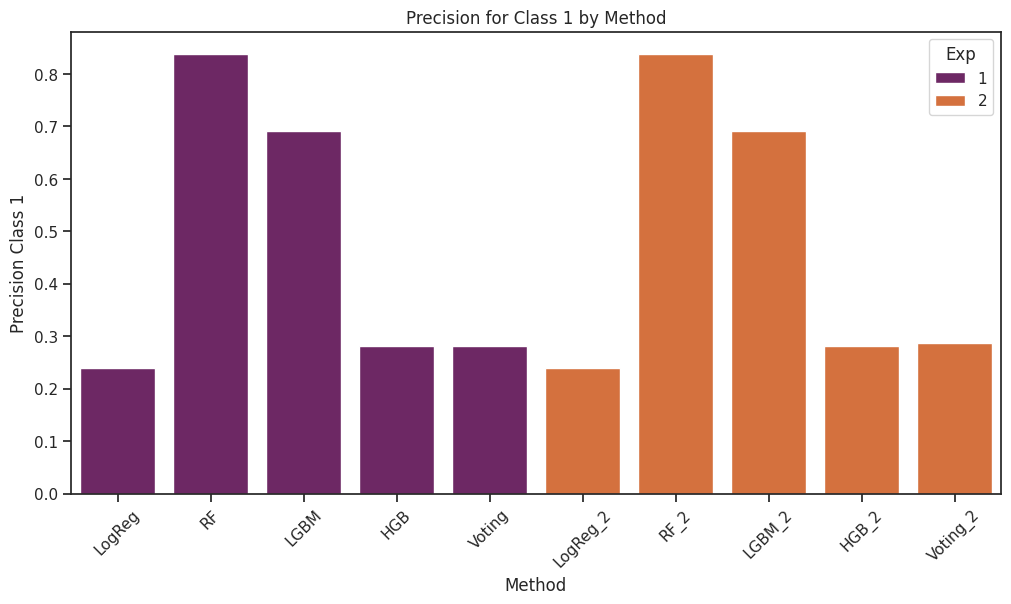

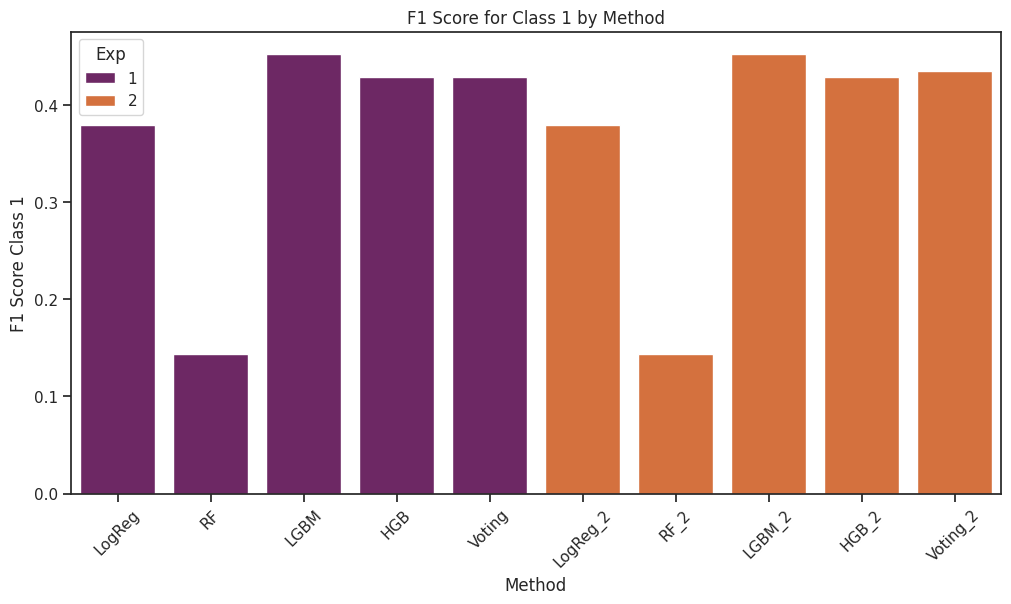

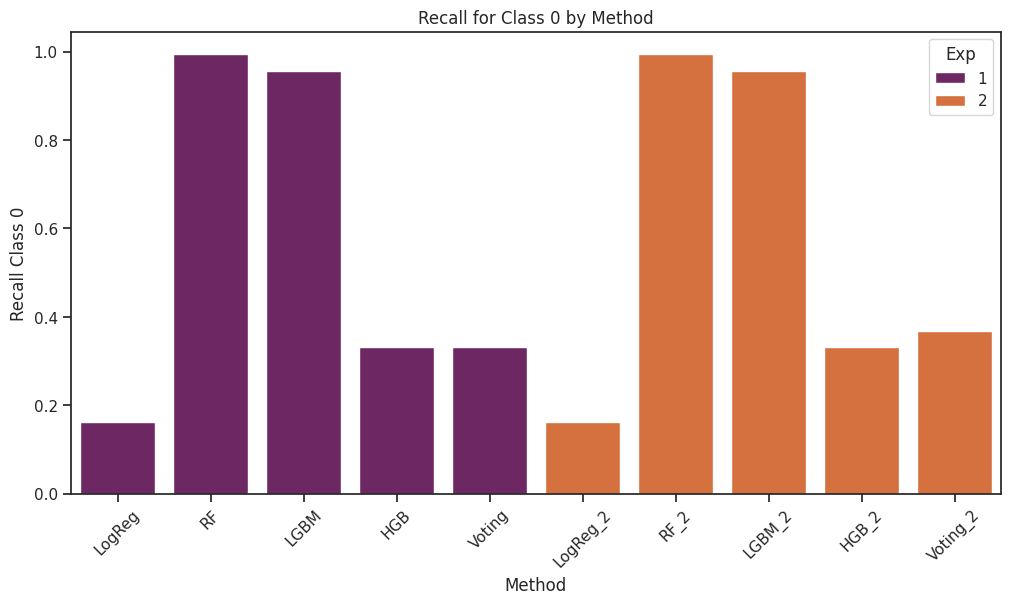

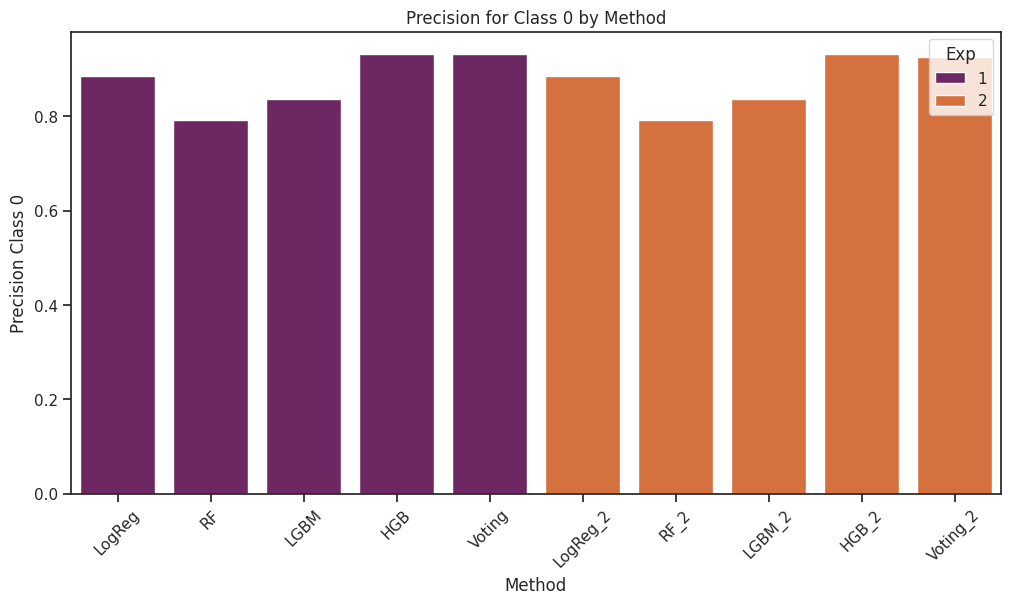

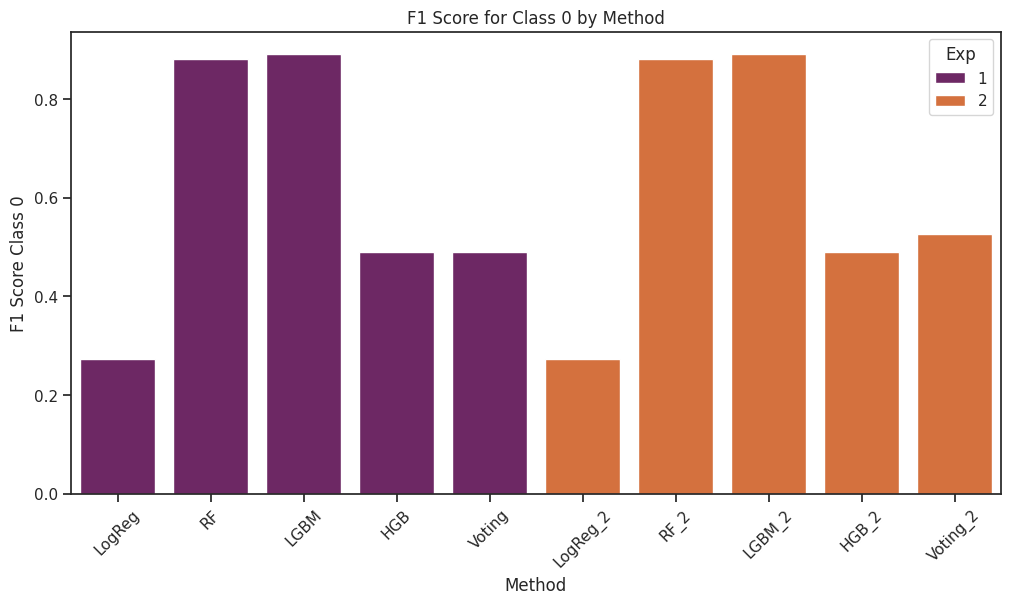

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Define constants for thresholds
LOW_THRESHOLD = 0.25
HIGH_THRESHOLD = 0.80

# Load and preprocess data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'

# Assuming the `load_and_preprocess_data` function is defined elsewhere
X, y = load_and_preprocess_data(url, categorical_columns, target)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['category']).columns.tolist()

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(drop='first'))
        ]), categorical_features)
    ])

# Define the models
models = {
    'LogReg': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'LGBM': LGBMClassifier(random_state=42, class_weight='balanced'),
    'HGB': HistGradientBoostingClassifier(random_state=42, class_weight='balanced')
}

# Create pipelines for each model
pipelines = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
             for name, model in models.items()}

# Function to fit models
def fit_models(pipelines, X_train, y_train):
    for name, pipeline in pipelines.items():
        pipeline.fit(X_train, y_train)

# Fit the models
fit_models(pipelines, X_train, y_train)

# Define the voting classifier
voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in models.items()],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf', voting_clf)
])

# Fit the final pipeline to the training data
pipeline.fit(X_train, y_train)

# Function to collect metrics
def collect_metrics(y_true, y_pred, method_name, threshold):
    recall_class1 = recall_score(y_true, y_pred, pos_label=1)
    precision_class1 = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1_class1 = f1_score(y_true, y_pred, pos_label=1)
    recall_class0 = recall_score(y_true, y_pred, pos_label=0)
    precision_class0 = precision_score(y_true, y_pred, pos_label=0, zero_division=0)
    f1_class0 = f1_score(y_true, y_pred, pos_label=0)

    return {
        'Method': method_name,
        'Threshold': threshold,
        'Recall Class 1': recall_class1,
        'Precision Class 1': precision_class1,
        'F1 Score Class 1': f1_class1,
        'Recall Class 0': recall_class0,
        'Precision Class 0': precision_class0,
        'F1 Score Class 0': f1_class0
    }

# Function to predict and collect results for a model
def predict_and_collect_results(pipeline, X_test, y_test, threshold, method_name):
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return collect_metrics(y_test, y_pred, method_name, threshold)

# Collect results for individual models
results = []
for name, pipeline in pipelines.items():
    threshold = LOW_THRESHOLD if name in ['LogReg', 'HGB'] else HIGH_THRESHOLD
    results.append(predict_and_collect_results(pipeline, X_test, y_test, threshold, name))

# Collect voting classifier results
results.append(predict_and_collect_results(pipeline, X_test, y_test, LOW_THRESHOLD, 'Voting'))

# Convert results to DataFrame and add test label
results_df = pd.DataFrame(results)
results_df['Exp'] = '1'

# Define models for experiment 2
models_2 = {name + '_2': model for name, model in models.items()}

# Create pipelines for each model in experiment 2
pipelines_2 = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
               for name, model in models_2.items()}

# Fit the models for experiment 2
fit_models(pipelines_2, X_train, y_train)

# Define the voting classifier for experiment 2
voting_clf_2 = VotingClassifier(
    estimators=[(name, model) for name, model in models_2.items()],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier for experiment 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf_2', voting_clf_2)
])

# Fit the final pipeline to the training data for experiment 2
pipeline_2.fit(X_train, y_train)

# Collect results for individual models in experiment 2
results2 = []
for name, pipeline in pipelines_2.items():
    threshold = LOW_THRESHOLD if 'LogReg' in name or 'HGB' in name else HIGH_THRESHOLD
    results2.append(predict_and_collect_results(pipeline, X_test, y_test, threshold, name))

# Collect voting classifier results for experiment 2
results2.append(predict_and_collect_results(pipeline_2, X_test, y_test, LOW_THRESHOLD, 'Voting_2'))

# Convert results to DataFrame and add test label
results_df2 = pd.DataFrame(results2)
results_df2['Exp'] = '2'

# Combine with previous results
combined_results_df = pd.concat([results_df, results_df2], ignore_index=True)

# Plot the combined results
def plot_combined_metrics(combined_results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Exp', data=combined_results_df, palette='inferno', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    plt.show()

metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('Precision Class 1', 'Precision for Class 1 by Method', 'Precision Class 1'),
    ('F1 Score Class 1', 'F1 Score for Class 1 by Method', 'F1 Score Class 1'),
    ('Recall Class 0', 'Recall for Class 0 by Method', 'Recall Class 0'),
    ('Precision Class 0', 'Precision for Class 0 by Method', 'Precision Class 0'),
    ('F1 Score Class 0', 'F1 Score for Class 0 by Method', 'F1 Score Class 0')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(combined_results_df, metric, title, ylabel)


In [13]:
# Save the combined results dataframe to a CSV file
combined_results_df.to_csv('combined_results.csv', index=False)
combined_results_df

,Method,Threshold,Recall Class 1,Precision Class 1,F1 Score Class 1,Recall Class 0,Precision Class 0,F1 Score Class 0,Exp
0,LogReg,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,1
1,RF,0.80,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,1
2,LGBM,0.80,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,1
3,HGB,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
4,Voting,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
5,LogReg_2,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,2
6,RF_2,0.80,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,2
7,LGBM_2,0.80,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,2
8,HGB_2,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,2
9,Voting_2,0.25,0.896760,0.287301,0.435180,0.368286,0.926265,0.527025,2


#### Interpretation of Results:

#### Key Metrics:
- **Recall Class 1**: High recall indicates a strong ability to identify actual positives (loan defaults).
- **Precision Class 1**: High precision indicates a lower rate of false positives.
- **F1 Score Class 1**: The harmonic mean of precision and recall, providing a balanced measure.

#### Experiment 1:
1. **LogReg**:
   - High Recall (0.925) for Class 1 but very low Precision (0.239), leading to a lot of false positives.
   - Low Recall (0.162) for Class 0, indicating many false negatives.

2. **RF**:
   - Very low Recall (0.078) for Class 1 but very high Precision (0.839), meaning fewer false positives.
   - Very high Recall (0.996) and good Precision (0.792) for Class 0.

3. **LGBM**:
   - Moderate Recall (0.337) and good Precision (0.691) for Class 1.
   - High Recall (0.957) and good Precision (0.836) for Class 0.
   - Balanced F1 Scores for both classes.

4. **HGB**:
   - High Recall (0.916) for Class 1 but low Precision (0.280).
   - Low Recall (0.333) for Class 0 but high Precision (0.933).

5. **Voting**:
   - Similar performance to HGB, influenced by HGB's results.

#### Experiment 2:
1. **LogReg_2**:
   - Identical performance to LogReg in Experiment 1.

2. **RF_2**:
   - Identical performance to RF in Experiment 1.

3. **LGBM_2**:
   - Identical performance to LGBM in Experiment 1.

4. **HGB_2**:
   - Identical performance to HGB in Experiment 1.

5. **Voting_2**:
   - Slightly lower Recall (0.897) for Class 1 compared to Voting in Experiment 1, but slightly higher Precision (0.287).
   - Improved Recall (0.368) for Class 0 compared to Voting in Experiment 1.

### Recommendations:

To maintain high recall for Class 1 (loan defaults) while improving precision, consider the following steps:

1. **Threshold Adjustment**:
   - Experiment with different thresholds to find a balance that maintains high recall while improving precision. Fine-tuning the threshold can significantly affect the trade-off between recall and precision.

2. **Model Tuning**:
   - Focus on hyperparameter tuning, particularly for the models showing better balance (like LGBM). Use grid search or random search to optimize parameters for improved precision.

3. **Feature Engineering**:
   - Enhance feature engineering to improve the model's ability to distinguish between classes. Create new features or transform existing ones to provide more predictive power.

4. **Ensemble Methods**:
   - Combine models that complement each other. For instance, use a weighted average voting classifier where models with higher precision contribute more to the final decision.

5. **Class Weight Adjustment**:
   - Adjust class weights to penalize false positives more heavily, thereby encouraging the model to prioritize precision.

6. **SMOTE or Resampling Techniques**:
   - Use Synthetic Minority Over-sampling Technique (SMOTE) or other resampling techniques to balance the dataset, improving the model's ability to generalize.



### Threshold Tuning

Best threshold: 0.6 with F1 Score: 0.536604062859333


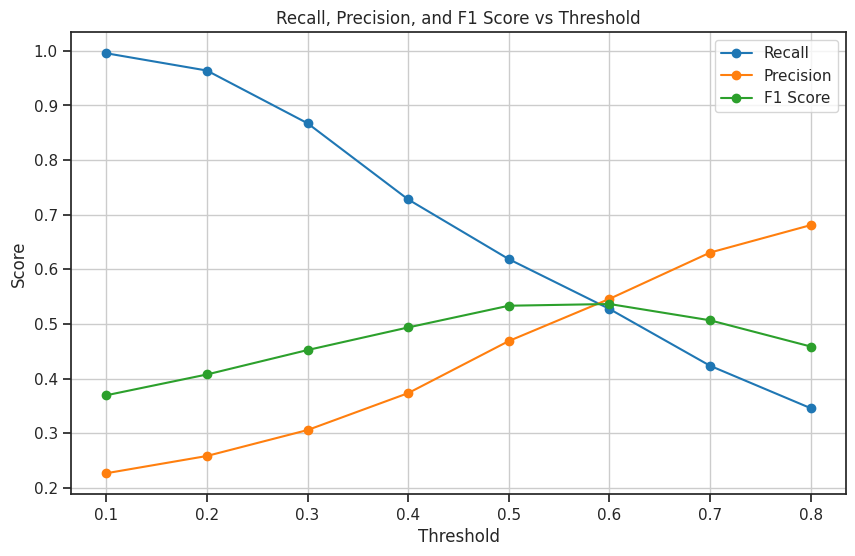

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

# Fine-tune thresholds for improved precision
thresholds = np.arange(0.1, 0.9, 0.1)
f1_scores = []
recall_scores = []
precision_scores = []

best_threshold = 0.25
best_f1 = 0

for threshold in thresholds:
    y_pred = (pipeline.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold} with F1 Score: {best_f1}')

# Plot Recall, Precision, and F1 Score against different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_scores, marker='o', label='Recall')
plt.plot(thresholds, precision_scores, marker='o', label='Precision')
plt.plot(thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Recall, Precision, and F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Combine thresholds and scores into a dataframe
scores_df = pd.DataFrame({
    'Threshold': thresholds,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'F1 Score': f1_scores
})

print(scores_df)

   Threshold    Recall  Precision  F1 Score
0        0.1  0.995479   0.226898  0.369562
1        0.2  0.963828   0.258488  0.407649
2        0.3  0.867370   0.305954  0.452348
3        0.4  0.727958   0.373550  0.493739
4        0.5  0.618689   0.468875  0.533463
5        0.6  0.527506   0.546022  0.536604
6        0.7  0.423512   0.630752  0.506763
7        0.8  0.345893   0.681009  0.458771


In [12]:
import numpy as np
from sklearn.metrics import classification_report

# Set the different thresholds for each class
low_threshold = 0.25
high_threshold = 0.8

# Predict probabilities using the model
probs = pipeline.predict_proba(X_test)[:, 1]

# Initialize predictions to zeros
mixed_threshold_pred = np.zeros_like(probs)

# Apply the low threshold for Class 1 (loan defaults)
mixed_threshold_pred[probs >= low_threshold] = 1

# Apply the high threshold for Class 0 (non-defaults)
mixed_threshold_pred[probs < high_threshold] = 0

# Handle cases between low_threshold and high_threshold
# If needed, this can be left as zeros or you can use other heuristics

# Evaluate the mixed threshold approach
recall = recall_score(y_test, mixed_threshold_pred, pos_label=1)
precision = precision_score(y_test, mixed_threshold_pred, pos_label=1, zero_division=0)
f1 = f1_score(y_test, mixed_threshold_pred, pos_label=1)

print(f'Mixed Threshold Approach:')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

# Classification report for detailed evaluation
print(classification_report(y_test, mixed_threshold_pred))


Mixed Threshold Approach:
Recall: 0.3458929917106255
Precision: 0.6810089020771514
F1 Score: 0.45877061469265373
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.68      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.76      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000



### Hyperparemeter Tuning

[LightGBM] [Info] Number of positive: 4248, number of negative: 14952
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3276
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.739657 -> initscore=1.044188
[LightGBM] [Info] Start training from score 1.044188
[LightGBM] [Info] Number of positive: 4247, number of negative: 14953
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001511 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3269
[LightGBM] [Info] Number of data points in the train set: 19200, number of used features: 30
[LightGBM] [Info] [bin

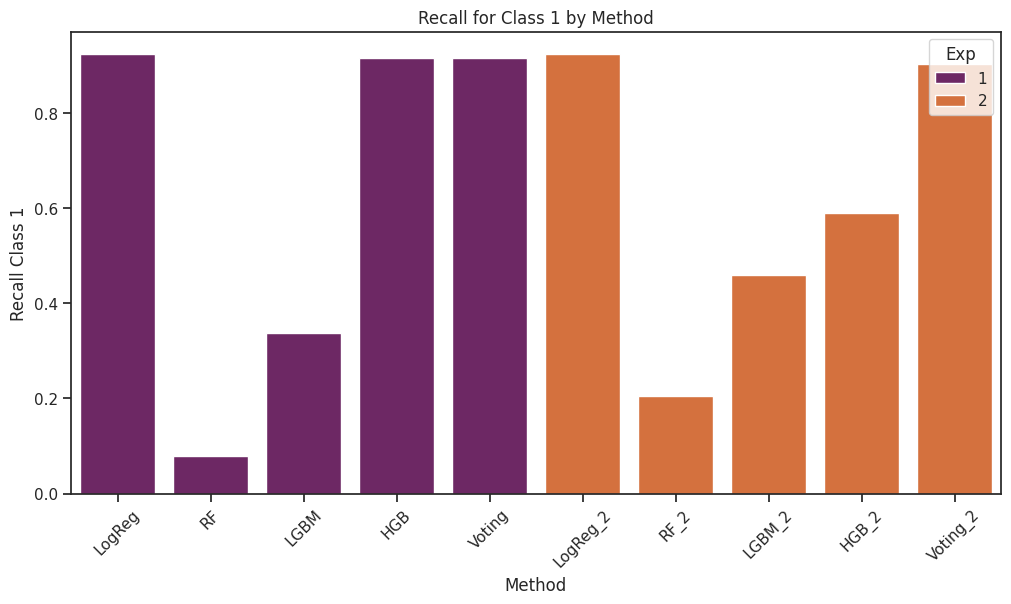

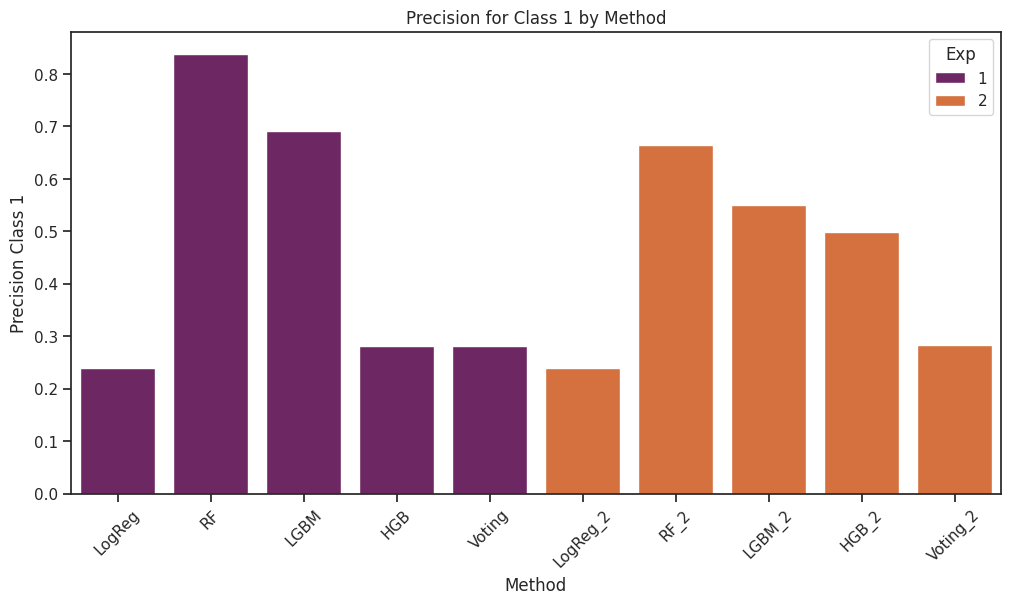

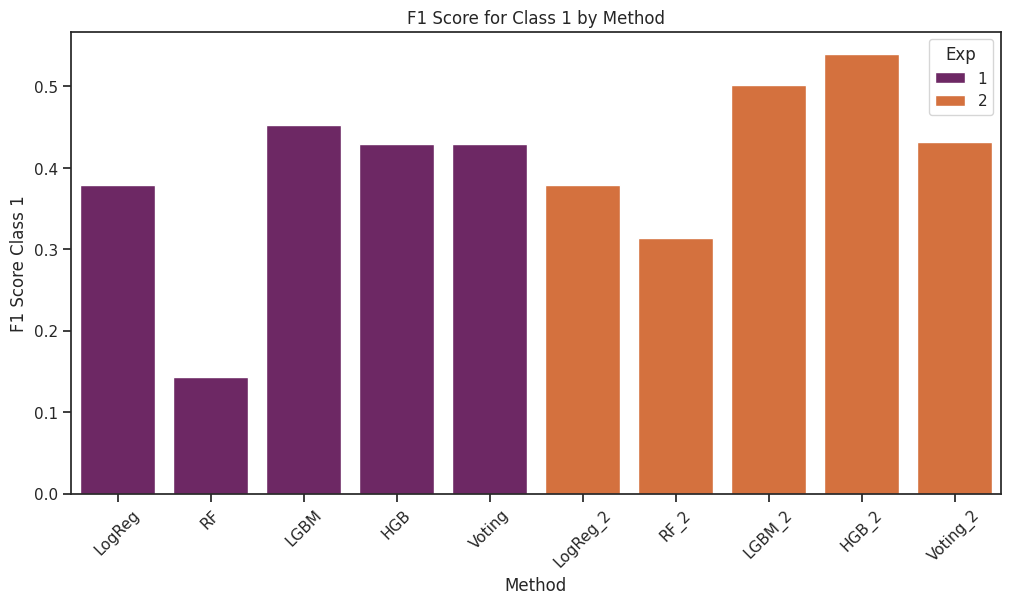

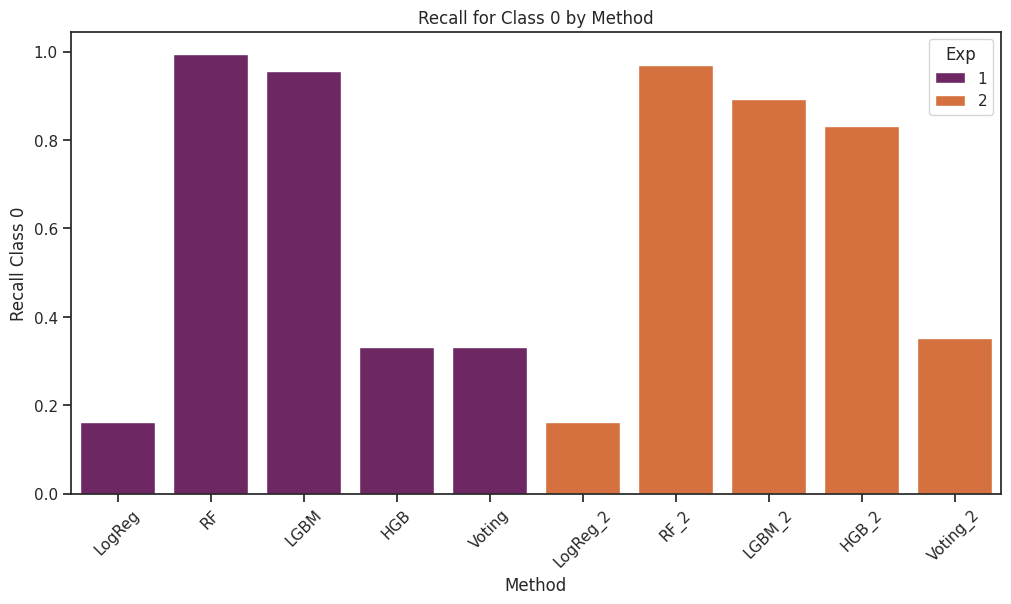

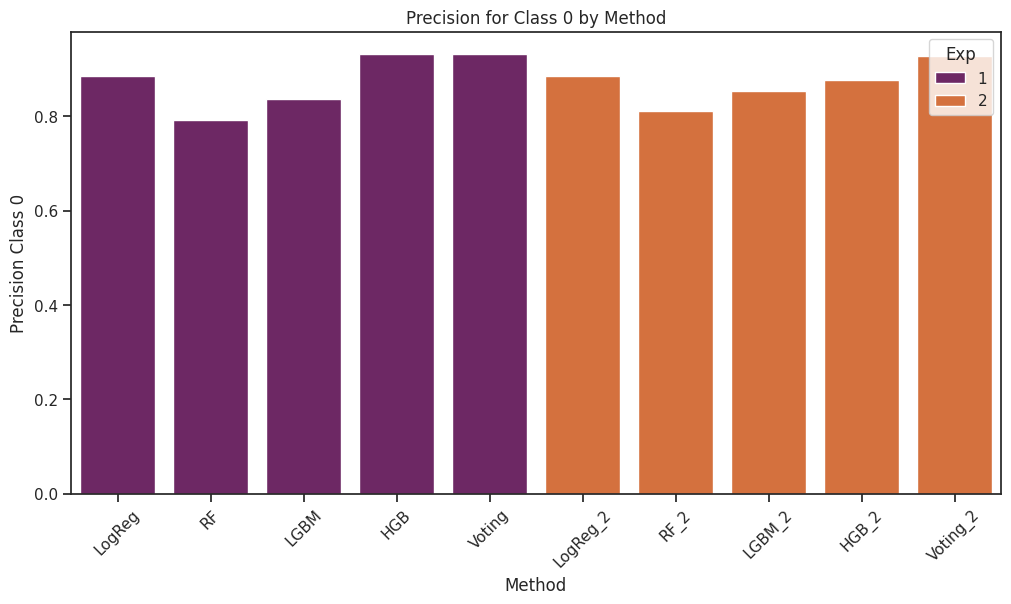

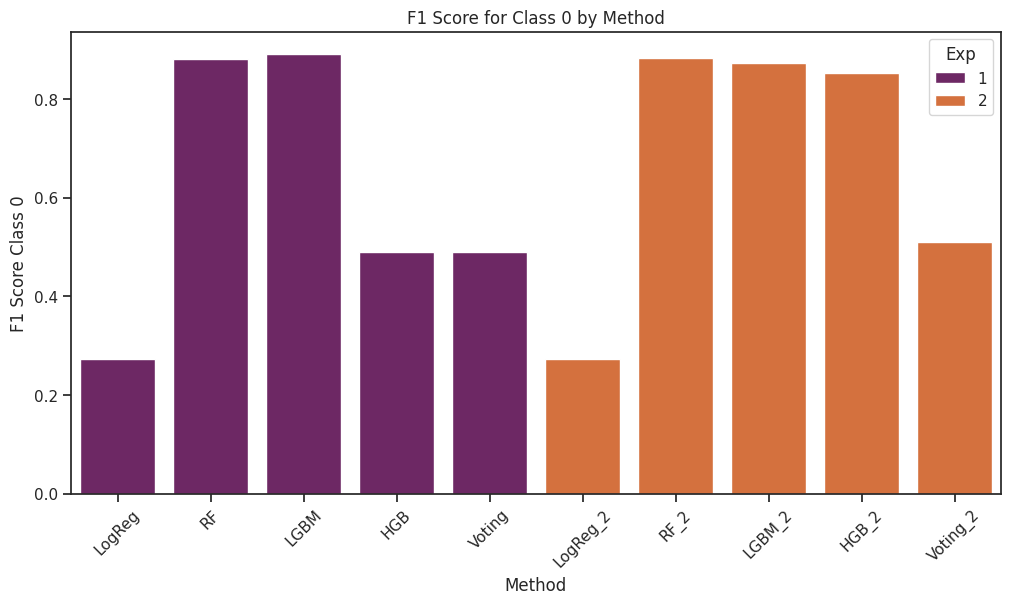

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the models for experiment 2 with modifications
models_2 = {
    'LogReg_2': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RF_2': RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 10}),  # Adjusted class weights
    'LGBM_2': LGBMClassifier(random_state=42, class_weight={0: 1, 1: 10}),        # Adjusted class weights
    'HGB_2': HistGradientBoostingClassifier(random_state=42)
}

# Create pipelines for each model in experiment 2
pipelines_2 = {name: Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
               for name, model in models_2.items()}

# Function to perform grid search for hyperparameter tuning
def tune_model(pipeline, param_grid, X_train, y_train, scoring='precision'):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scoring)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Hyperparameter grids for tuning
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

param_grid_lgbm = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__num_leaves': [31, 61],
    'classifier__max_depth': [-1, 10, 20]
}

# Tune RF and LGBM models for higher precision
pipelines_2['RF_2'] = tune_model(pipelines_2['RF_2'], param_grid_rf, X_train, y_train)
pipelines_2['LGBM_2'] = tune_model(pipelines_2['LGBM_2'], param_grid_lgbm, X_train, y_train)

# Fit the models for experiment 2
fit_models(pipelines_2, X_train, y_train)

# Define the voting classifier for experiment 2
voting_clf_2 = VotingClassifier(
    estimators=[(name, model) for name, model in models_2.items()],
    voting='soft'  # Use soft voting for probabilities
)

# Create the final pipeline with the preprocessor and voting classifier for experiment 2
pipeline_2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('voting_clf_2', voting_clf_2)
])

# Fit the final pipeline to the training data for experiment 2
pipeline_2.fit(X_train, y_train)

# Collect results for individual models in experiment 2
results2 = []
for name, pipeline in pipelines_2.items():
    threshold = LOW_THRESHOLD if 'LogReg' in name or 'HGB' in name else HIGH_THRESHOLD
    results2.append(predict_and_collect_results(pipeline, X_test, y_test, threshold, name))

# Collect voting classifier results for experiment 2
results2.append(predict_and_collect_results(pipeline_2, X_test, y_test, LOW_THRESHOLD, 'Voting_2'))

# Convert results to DataFrame and add test label
results_df2 = pd.DataFrame(results2)
results_df2['Exp'] = '2'

# Combine with previous results
combined_results_df = pd.concat([results_df, results_df2], ignore_index=True)

# Save the combined results dataframe to a CSV file
combined_results_df.to_csv('combined_results.csv', index=False)

# Plot the combined results
def plot_combined_metrics(combined_results_df, metric, title, ylabel):
    sns.set_context('notebook')
    sns.set_style('ticks')
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.barplot(x='Method', y=metric, hue='Exp', data=combined_results_df, palette='inferno', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Method')
    ax.set_ylabel(ylabel)

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    plt.show()

metrics = [
    ('Recall Class 1', 'Recall for Class 1 by Method', 'Recall Class 1'),
    ('Precision Class 1', 'Precision for Class 1 by Method', 'Precision Class 1'),
    ('F1 Score Class 1', 'F1 Score for Class 1 by Method', 'F1 Score Class 1'),
    ('Recall Class 0', 'Recall for Class 0 by Method', 'Recall Class 0'),
    ('Precision Class 0', 'Precision for Class 0 by Method', 'Precision Class 0'),
    ('F1 Score Class 0', 'F1 Score for Class 0 by Method', 'F1 Score Class 0')
]

# Loop through the metrics and create plots
for metric, title, ylabel in metrics:
    plot_combined_metrics(combined_results_df, metric, title, ylabel)


In [15]:
combined_results_df

,Method,Threshold,Recall Class 1,Precision Class 1,F1 Score Class 1,Recall Class 0,Precision Class 0,F1 Score Class 0,Exp
0,LogReg,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,1
1,RF,0.80,0.078372,0.838710,0.143349,0.995720,0.791865,0.882169,1
2,LGBM,0.80,0.336850,0.690881,0.452888,0.957201,0.835606,0.892280,1
3,HGB,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
4,Voting,0.25,0.915599,0.280341,0.429253,0.332549,0.932773,0.490298,1
5,LogReg_2,0.25,0.925396,0.238678,0.379481,0.161780,0.884211,0.273517,2
6,RF_2,0.80,0.204974,0.665037,0.313364,0.970683,0.811304,0.883866,2
7,LGBM_2,0.80,0.460437,0.550947,0.501642,0.893430,0.853609,0.873066,2
8,HGB_2,0.25,0.590806,0.497778,0.540317,0.830730,0.877288,0.853374,2
9,Voting_2,0.25,0.902788,0.283416,0.431401,0.351808,0.927242,0.510084,2


### Interpretation of Results:

#### Key Metrics:
- **Recall Class 1**: Measures the ability to correctly identify actual positives (loan defaults).
- **Precision Class 1**: Measures the ability to correctly identify predicted positives (loan defaults).
- **F1 Score Class 1**: The harmonic mean of precision and recall for Class 1.
- **Recall Class 0**: Measures the ability to correctly identify actual negatives (non-defaults).
- **Precision Class 0**: Measures the ability to correctly identify predicted negatives (non-defaults).
- **F1 Score Class 0**: The harmonic mean of precision and recall for Class 0.

### Experiment 1 Results:
1. **LogReg**:
   - High Recall (0.925) for Class 1, but very low Precision (0.239), indicating many false positives.
   - Low Recall (0.162) for Class 0, indicating many false negatives.
   - Low overall F1 Score for both classes.

2. **RF**:
   - Extremely low Recall (0.078) for Class 1, but very high Precision (0.839), indicating fewer false positives.
   - Very high Recall (0.996) and good Precision (0.792) for Class 0.
   - F1 Score is very low for Class 1 due to poor Recall.

3. **LGBM**:
   - Moderate Recall (0.337) and good Precision (0.691) for Class 1.
   - High Recall (0.957) and good Precision (0.836) for Class 0.
   - Balanced F1 Scores for both classes, with better overall performance than RF.

4. **HGB**:
   - High Recall (0.916) for Class 1 but low Precision (0.280).
   - Low Recall (0.333) for Class 0 but high Precision (0.933).
   - Improved F1 Score for Class 1 compared to LogReg.

5. **Voting**:
   - Similar performance to HGB, indicating the voting classifier's performance is influenced by HGB's results.

### Experiment 2 Results:
1. **LogReg_2**:
   - Identical performance to LogReg in Experiment 1, indicating no change was applied.

2. **RF_2**:
   - Improved Recall (0.205) for Class 1 compared to RF in Experiment 1.
   - Slightly lower Precision (0.665) for Class 1 compared to RF in Experiment 1, indicating a better balance.
   - Improved F1 Score (0.313) for Class 1 compared to RF in Experiment 1.
   - High Recall (0.971) and good Precision (0.811) for Class 0.

3. **LGBM_2**:
   - Improved Recall (0.460) for Class 1 compared to LGBM in Experiment 1.
   - Lower Precision (0.551) for Class 1 compared to LGBM in Experiment 1, indicating a better balance.
   - Improved F1 Score (0.502) for Class 1 compared to LGBM in Experiment 1.
   - Lower Recall (0.893) and slightly lower Precision (0.854) for Class 0 compared to LGBM in Experiment 1.

4. **HGB_2**:
   - Significantly lower Recall (0.591) for Class 1 compared to HGB in Experiment 1.
   - Improved Precision (0.498) for Class 1 compared to HGB in Experiment 1.
   - Improved F1 Score (0.540) for Class 1 compared to HGB in Experiment 1.
   - Lower Recall (0.831) and good Precision (0.877) for Class 0.

5. **Voting_2**:
   - Slightly lower Recall (0.903) for Class 1 compared to Voting in Experiment 1.
   - Slightly improved Precision (0.283) for Class 1 compared to Voting in Experiment 1.
   - Similar F1 Score (0.431) for Class 1 compared to Voting in Experiment 1.
   - Slightly lower Recall (0.352) and similar Precision (0.927) for Class 0.

### Recommendations:
To maintain high recall for Class 1 while improving precision, consider the following steps:

1. **Fine-Tune Thresholds**:
   - Experiment with different thresholds to find the optimal balance between recall and precision.
   - Consider using separate thresholds for different classes, as suggested earlier.

2. **Further Hyperparameter Tuning**:
   - Continue tuning hyperparameters, especially for `RF_2` and `LGBM_2`, focusing on achieving higher precision without significantly sacrificing recall.

3. **Ensemble Methods**:
   - Use a weighted voting classifier to give more weight to models that achieve higher precision for Class 1 while maintaining high recall.

4. **Use SMOTE or Resampling Techniques**:
   - Apply Synthetic Minority Over-sampling Technique (SMOTE) or other resampling techniques to balance the dataset, potentially improving both recall and precision.

5. **Model Stacking**:
   - Consider stacking different models to leverage their strengths, combining models with high recall and high precision to achieve a balanced performance.

This approach allows you to fine-tune the thresholds further, ensuring that you achieve a balance between recall and precision for Class 1, ultimately improving the model's performance.

### Threshold Tuning

Best threshold: 0.5 with F1 Score: 0.5243027888446216
   Threshold    Recall  Precision  F1 Score
0        0.1  0.996986   0.225884  0.368318
1        0.2  0.959307   0.252931  0.400314
2        0.3  0.815373   0.323082  0.462789
3        0.4  0.623210   0.447996  0.521273
4        0.5  0.495855   0.556213  0.524303
5        0.6  0.397136   0.634176  0.488415
6        0.7  0.293142   0.698384  0.412951
7        0.8  0.134137   0.798206  0.229677


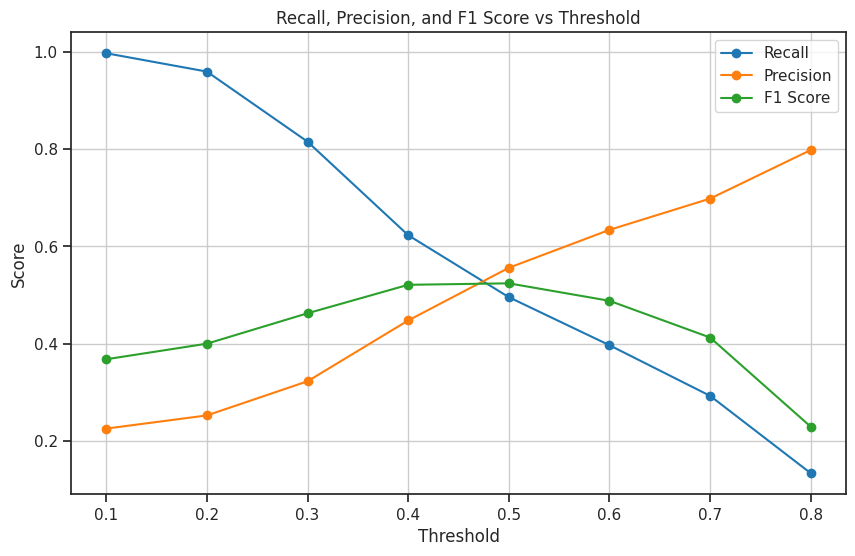

In [16]:
import numpy as np
from sklearn.metrics import f1_score, recall_score, precision_score

# Define thresholds for fine-tuning
fine_thresholds = np.arange(0.1, 0.9, 0.1)
f1_scores = []
recall_scores = []
precision_scores = []

best_threshold = 0.25
best_f1 = 0

for threshold in fine_thresholds:
    y_pred = (pipeline_2.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    recall = recall_score(y_test, y_pred, pos_label=1)
    precision = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    recall_scores.append(recall)
    precision_scores.append(precision)
    f1_scores.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold} with F1 Score: {best_f1}')

# Combine fine-tuned thresholds and scores into a dataframe
scores_df = pd.DataFrame({
    'Threshold': fine_thresholds,
    'Recall': recall_scores,
    'Precision': precision_scores,
    'F1 Score': f1_scores
})

print(scores_df)

# Plot Recall, Precision, and F1 Score against different thresholds
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(fine_thresholds, recall_scores, marker='o', label='Recall')
plt.plot(fine_thresholds, precision_scores, marker='o', label='Precision')
plt.plot(fine_thresholds, f1_scores, marker='o', label='F1 Score')
plt.title('Recall, Precision, and F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


#### Write Loan Data Utils Script

In [2]:
script_content=r'''
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def load_data_from_url(url):
    try:
        df = pd.read_excel(url, header=1)
        logging.info("Data loaded successfully from URL.")
    except Exception as e:
        logging.error(f"Error loading data from URL: {e}")
        return None
    return df

def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

def rename_columns(df):
    rename_dict = {'pay_0': 'pay_1'}
    df = df.rename(columns=rename_dict)
    return df

def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

def split_features_target(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    return X, y

def load_and_preprocess_data(url, categorical_columns, target):
    df = load_data_from_url(url)
    if df is not None:
        df = clean_column_names(df)
        df = remove_id_column(df)
        df = rename_columns(df)
        df = convert_categorical(df, categorical_columns)
        X, y = split_features_target(df, target)
        return X, y
    return None, None

def plot_class_distribution(y_train, target_name):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='mako')
    plt.title(f'Class Distribution in Training Set: {target_name}')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.legend([], [], frameon=False)

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()


'''

# Write the script to a file
with open("loan_data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to loan_data_utils.py")
# Reload script to make functions available for use
import importlib
import loan_data_utils
importlib.reload(loan_data_utils)

from loan_data_utils import *


Script successfully written to loan_data_utils.py
